# Actividad de la Semana 04

**Maestría en Inteligencia Artificial Aplicada**  
**Curso:** Proyecto Integrador  
**Institución:** Instituto Tecnológico de Monterrey  
**Profesor titular:** Dra. Grettel Barceló Alonso  
**Profesor titular:** Dr. Luis Eduardo Falcón Morales  
**Profesora asistente** Mtra. Verónica Sandra Guzmán de Valle  

---

**Avance** #2

**Actividad** Ingeniería de características


---

**Nombre del estudiante:** María Figueroa Bejarano  **Matrícula:** *A01114853*

**Nombre del estudiante:** David Hernández Castellanos  
**Matrícula:** *A01795964*

**Nombre del estudiante:** Francisco Javier Ramírez Arias
**Matrícula:** A01316379  

---

## Avance 2. Ingeniería de Características (Feature Engineering)

En este avance se desarrolla la fase de **Ingeniería de Características (Feature Engineering)**, correspondiente a la etapa de **Preparación de los Datos** dentro de la metodología CRISP-ML(Q). El objetivo principal es transformar los datos crudos del mundo real (imágenes microscópicas) en representaciones numéricas que faciliten el aprendizaje automático, mejoren la capacidad de generalización de los modelos y reduzcan riesgos asociados a sesgos, escalas heterogéneas y alta dimensionalidad.

De manera específica, este avance aborda los siguientes objetivos:

- **2.3** Crear nuevas características que aporten información relevante para la clasificación multiclase de imágenes.
- **2.4** Mitigar el riesgo de características sesgadas y acelerar la convergencia de los algoritmos mediante normalización, transformaciones y reducción de dimensionalidad.


## Feature Engineering en el contexto de CRISP-ML(Q)

De acuerdo con la metodología **CRISP-ML(Q)**, la fase de *Data Preparation* tiene como finalidad convertir los datos iniciales en un conjunto de variables adecuado para el modelado, garantizando calidad, reproducibilidad y trazabilidad del proceso. En esta etapa se realizan actividades como limpieza, transformación, creación de nuevas características y reducción de complejidad, sentando las bases para un entrenamiento eficiente y confiable de los modelos.

En este proyecto, la preparación de los datos se enfoca en imágenes médicas, lo que implica retos particulares como variaciones de iluminación, tinción, resolución y distribución de clases, los cuales deben abordarse explícitamente durante la ingeniería de características.


## Paqueterías

In [1]:
import os, random
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from google.colab import drive

from sklearn.preprocessing import PowerTransformer


## Carga de datos

In [2]:

RANDOM_SEED = 6
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

drive.mount('/content/drive')

dataset_path = Path("/content/drive/MyDrive/MNA/Proyecto Integrador/PBC_dataset_normal_DIB")

def get_class_folders(base_path: Path):
    classes = sorted([d.name for d in base_path.iterdir() if d.is_dir() and not d.name.startswith(".")])
    return classes

classes = get_class_folders(dataset_path)
classes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['basophil',
 'eosinophil',
 'erythroblast',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet']

### Descripción del dataset

El dataset contiene:

• 17,092 imágenes digitales de células individuales de sangre.

• Las imágenes fueron adquiridas con el analizador automático CellaVision DM96,
en formato JPG, con resolución aproximada 360 x 360 pixeles y en un espacio de color RGB.

• Todas las imágenes están etiquetadas manualmente por patólogos clínicos expertos.

• Los datos esta anonimizados, sin información que permita identificar a los
pacientes.

• Las muestras provienen de individuos sanos, sin infecciones, enfermedades
hematológicas u oncológicas, y sin tratamiento farmacológico al momento de la
extracción.

• Las imágenes están organizadas en ocho clases de células sanguíneas normales: a)Neutrófilos, b) Eosinófilo, c) Basófilos, d) Linfocitos, e) Monocitos, f)
Granulocitos, h) Eritroblastos, i) Plaquetas

El dataset es open source de "A dataset for microscopic peripheral blood cell images for development of automatic recognition systems,” Mendeley Data. https://data.mendeley.com/datasets/snkd93bnjr/1

## Feature Engineering/Preprocesamiento de imágenes

Como paso previo a la ingeniería de características, las imágenes son sometidas a un preprocesamiento estándar que incluye:

- **Redimensionamiento (resize)** a una resolución uniforme, con el objetivo de garantizar entradas homogéneas al modelo.
- **Normalización de intensidades**, necesaria para estabilizar el entrenamiento y evitar problemas numéricos en redes neuronales y clasificadores sensibles a la escala.
- **Muestreo estratificado y balanceado**, utilizado para reducir el costo computacional durante esta fase sin perder representatividad de las clases.

Estas decisiones permiten acelerar la experimentación en la fase de Feature Engineering y asegurar consistencia en los resultados.


### 1. Index

In [3]:
IMG_EXT = {".jpg", ".jpeg", ".png"}

rows = []
for cls in classes:
    cls_dir = dataset_path / cls
    for p in cls_dir.iterdir():
        if p.suffix.lower() in IMG_EXT and not p.name.startswith("."):
            rows.append({"path": str(p), "class": cls})

df_index = pd.DataFrame(rows)
print(df_index.shape)
df_index["class"].value_counts()

(17092, 2)


,count
class,
neutrophil,3329
eosinophil,3117
ig,2895
platelet,2348
erythroblast,1551
monocyte,1420
basophil,1218
lymphocyte,1214


In [4]:
SAMPLES_PER_CLASS = 2000

df_sample = (
    df_index.groupby("class", group_keys=False)
    .apply(lambda g: g.sample(n=min(SAMPLES_PER_CLASS, len(g)), random_state=42))
    .reset_index(drop=True)
)

print("Subset:", df_sample.shape)
print(df_sample["class"].value_counts())

Subset: (13403, 2)
class
eosinophil      2000
ig              2000
neutrophil      2000
platelet        2000
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: count, dtype: int64


/tmp/ipython-input-1843859344.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(SAMPLES_PER_CLASS, len(g)), random_state=42))


## 2. Preprocesamiento base para modelos

### 2.1 Normalización + resize (modelo) + split estratificado

In [5]:
IMG_SIZE = (224, 224)
BATCH = 128

train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=RANDOM_SEED, stratify=df_sample["class"])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=RANDOM_SEED, stratify=train_df["class"])

print(train_df.shape, val_df.shape, test_df.shape)

(8577, 2) (2145, 2) (2681, 2)


### 2.2 Extracción de características profundas (Deep Feature Extraction)

Una de las estrategias principales de ingeniería de características empleadas consiste en la **extracción de características profundas (deep features)** mediante una red neuronal convolucional preentrenada. En particular, se utiliza un modelo EfficientNet entrenado sobre ImageNet como extractor de representaciones latentes.

Este enfoque permite transformar cada imagen en un vector denso de características que captura patrones espaciales, texturales y morfológicos complejos, sin necesidad de entrenar una red desde cero. El uso de modelos preentrenados es una práctica común en visión por computadora, ya que mejora la generalización y reduce los requerimientos de datos y tiempo de entrenamiento.


In [6]:

AUTOTUNE = tf.data.AUTOTUNE

classes = sorted(df_index["class"].unique().tolist())
class_to_id = {c:i for i,c in enumerate(classes)}

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

def image_scalar_features(img):
    """
    img: tensor float32 [H,W,3] (ya resize aplicado), rango 0-255 aprox
    Retorna: [brightness, contrast, colorfulness_proxy, ratio_RG, ratio_RB, ratio_GB]
    """
    img01 = img / 255.0

    mean_rgb = tf.reduce_mean(img01, axis=[0,1])  # [3]
    std_rgb  = tf.math.reduce_std(img01, axis=[0,1])  # [3]

    # Brightness (luma perceptual)
    brightness = 0.299*mean_rgb[0] + 0.587*mean_rgb[1] + 0.114*mean_rgb[2]
    # Contrast proxy
    contrast = tf.reduce_mean(std_rgb)

    eps = 1e-6
    ratio_RG = mean_rgb[0] / (mean_rgb[1] + eps)
    ratio_RB = mean_rgb[0] / (mean_rgb[2] + eps)
    ratio_GB = mean_rgb[1] / (mean_rgb[2] + eps)

    # Colorfulness proxy (rápida): std(R-G) + std(0.5*(R+G)-B)
    rg = img01[:,:,0] - img01[:,:,1]
    yb = 0.5*(img01[:,:,0] + img01[:,:,1]) - img01[:,:,2]
    colorfulness = tf.math.reduce_std(rg) + tf.math.reduce_std(yb)

    return tf.stack([brightness, contrast, colorfulness, ratio_RG, ratio_RB, ratio_GB])

def make_ds(df, shuffle=False):
    paths  = df["path"].values
    labels = df["class"].map(class_to_id).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(4096, seed=42)
    ds = ds.batch(BATCH, drop_remainder=False)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

def image_scalar_features(img):
    img01 = img / 255.0
    mean_rgb = tf.reduce_mean(img01, axis=[0,1])
    std_rgb  = tf.math.reduce_std(img01, axis=[0,1])

    brightness = 0.299*mean_rgb[0] + 0.587*mean_rgb[1] + 0.114*mean_rgb[2]
    contrast   = tf.reduce_mean(std_rgb)

    eps = 1e-6
    ratio_RG = mean_rgb[0] / (mean_rgb[1] + eps)
    ratio_RB = mean_rgb[0] / (mean_rgb[2] + eps)
    ratio_GB = mean_rgb[1] / (mean_rgb[2] + eps)

    rg = img01[:,:,0] - img01[:,:,1]
    yb = 0.5*(img01[:,:,0] + img01[:,:,1]) - img01[:,:,2]
    colorfulness = tf.math.reduce_std(rg) + tf.math.reduce_std(yb)

    return tf.stack([brightness, contrast, colorfulness, ratio_RG, ratio_RB, ratio_GB])

def load_image_with_feats(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    feats = image_scalar_features(img)
    return img, feats, label

train_ds = make_ds(train_df, shuffle=True)
val_ds   = make_ds(val_df)
test_ds  = make_ds(test_df)

Construcción de características adicionales

Además de las características profundas, se construyen explícitamente **nuevas variables derivadas de las imágenes** con bajo costo computacional, orientadas a capturar propiedades físicas relevantes del dominio:

- **Brightness (luminancia)**: aproxima el nivel global de iluminación de la imagen.
- **Contrast**: mide la variabilidad de intensidades, asociada a bordes y estructura.
- **Colorfulness**: captura la riqueza cromática y posibles diferencias de tinción.
- **Ratios entre canales RGB**: reducen el efecto de cambios globales de iluminación y resaltan diferencias relativas entre canales.

Estas características complementan a los embeddings profundos y ayudan a mitigar sesgos derivados de condiciones de adquisición, aportando interpretabilidad y señal adicional al modelo.


### 2.3 Extracción de embeddings

In [7]:
def load_image_with_feats(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    feats = image_scalar_features(img)
    return img, feats, label

def make_ds_feats(df, shuffle=False):
    paths  = df["path"].values
    labels = df["class"].map(class_to_id).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image_with_feats, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(4096, seed=RANDOM_SEED)
    ds = ds.batch(BATCH, drop_remainder=False).prefetch(AUTOTUNE)
    return ds

train_ds_f = make_ds_feats(train_df, shuffle=False)
val_ds_f   = make_ds_feats(val_df, shuffle=False)
test_ds_f  = make_ds_feats(test_df, shuffle=False)




In [8]:
base = EfficientNetB1(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
embed_model = Model(inputs, x, name="embedder")

embed_model.output_shape

(None, 1280)

In [9]:
train_imgs = train_ds_f.map(lambda x, f, y: x)
val_imgs   = val_ds_f.map(lambda x, f, y: x)
test_imgs  = test_ds_f.map(lambda x, f, y: x)

X_train_emb = embed_model.predict(train_imgs, verbose=1)
X_val_emb   = embed_model.predict(val_imgs, verbose=1)
X_test_emb  = embed_model.predict(test_imgs, verbose=1)

train_feats = np.vstack([f.numpy() for _, f, _ in train_ds_f.unbatch().batch(2048)])
val_feats   = np.vstack([f.numpy() for _, f, _ in val_ds_f.unbatch().batch(2048)])
test_feats  = np.vstack([f.numpy() for _, f, _ in test_ds_f.unbatch().batch(2048)])

X_train = np.hstack([X_train_emb, train_feats])
X_val   = np.hstack([X_val_emb, val_feats])
X_test  = np.hstack([X_test_emb, test_feats])

print("Final features:", X_train.shape)

y_train = train_df["class"].map(class_to_id).values
y_val   = val_df["class"].map(class_to_id).values
y_test  = test_df["class"].map(class_to_id).values


68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 401ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Final features: (8577, 1286)


In [10]:
np.save("X_train_emb.npy", X_train_emb)
np.save("y_train.npy", y_train)
np.save("X_val_emb.npy", X_val_emb)
np.save("y_val.npy", y_val)
np.save("X_test_emb.npy", X_test_emb)
np.save("y_test.npy", y_test)

print("Guardado embeddings .npy")

Guardado embeddings .npy


Además de extraer embeddings con un modelo preentrenado (extracción de características), se generaron nuevas características de bajo costo computacional (brightness, contrast, colorfulness y ratios entre canales), diseñadas para capturar variaciones de iluminación/tinción. Estas variables ayudan a mitigar sesgos de adquisición y aportan señal complementaria al embedding, mejorando potencialmente la generalización.

### 2.4 Normalización y transformaciones de las características

Dado que las características extraídas y construidas presentan escalas heterogéneas, se aplican técnicas de **escalamiento** para garantizar que todas las variables contribuyan de manera equilibrada al aprendizaje. En particular, se emplea:

- **Estandarización (StandardScaler)** para centrar las variables y normalizar su varianza.
- **Transformación de potencia Yeo–Johnson**, evaluada como alternativa para reducir asimetrías en las distribuciones sin requerir que los datos sean estrictamente positivos.

Estas transformaciones son especialmente relevantes para algoritmos sensibles a la escala, como regresión logística, SVM o redes neuronales, ya que mejoran la estabilidad numérica y aceleran la convergencia del entrenamiento.


In [19]:
pipe_lr_std = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))
])

pipe_lr_yj = Pipeline([
    ("scaler", StandardScaler()),
    ("pt", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))
])

pipe_lr_std.fit(X_train, y_train)
pred_std = pipe_lr_std.predict(X_val)

pipe_lr_yj.fit(X_train, y_train)
pred_yj = pipe_lr_yj.predict(X_val)

print("=== StandardScaler ===")
print(classification_report(y_val, pred_std, target_names=classes))
print("=== StandardScaler + Yeo-Johnson ===")
print(classification_report(y_val, pred_yj, target_names=classes))

=== StandardScaler ===
              precision    recall  f1-score   support

    basophil       0.93      0.92      0.93       195
  eosinophil       0.95      0.96      0.96       320
erythroblast       0.93      0.94      0.94       249
          ig       0.87      0.90      0.88       320
  lymphocyte       0.96      0.94      0.95       194
    monocyte       0.89      0.86      0.88       227
  neutrophil       0.93      0.93      0.93       320
    platelet       0.99      0.98      0.99       320

    accuracy                           0.93      2145
   macro avg       0.93      0.93      0.93      2145
weighted avg       0.93      0.93      0.93      2145

=== StandardScaler + Yeo-Johnson ===
              precision    recall  f1-score   support

    basophil       0.95      0.94      0.95       195
  eosinophil       0.93      0.98      0.96       320
erythroblast       0.97      0.93      0.95       249
          ig       0.88      0.91      0.89       320
  lymphocyte      

Se evalúa Yeo–Johnson como transformación de potencia para reducir asimetrías sin requerir positividad estricta, lo cual puede mejorar estabilidad y convergencia de algoritmos lineales sobre representaciones densas.

## Selección y extracción de características

Con el objetivo de reducir la complejidad del modelo y los requerimientos de cómputo, se aplican técnicas de **selección y extracción de características** fundamentadas en criterios estadísticos:

- **Umbral de varianza (Variance Threshold)**, para eliminar características constantes o con baja variabilidad.
- **ANOVA (SelectKBest)**, como método de filtrado supervisado que identifica las variables con mayor capacidad discriminativa entre clases.
- **Análisis de Componentes Principales (PCA)**, utilizado como técnica de extracción para proyectar las características en un espacio de menor dimensionalidad preservando la mayor parte de la varianza explicativa.

Estas técnicas permiten reducir redundancia, mejorar interpretabilidad y facilitar el entrenamiento de modelos posteriores.


### Umbral de varianza

In [12]:
vt = VarianceThreshold(threshold=0.0)
X_train_vt = vt.fit_transform(X_train_emb)
X_val_vt   = vt.transform(X_val_emb)
X_test_vt  = vt.transform(X_test_emb)

X_train_vt.shape

(8577, 1280)

###PCA

n_components: 204
var acumulada: 0.95017666


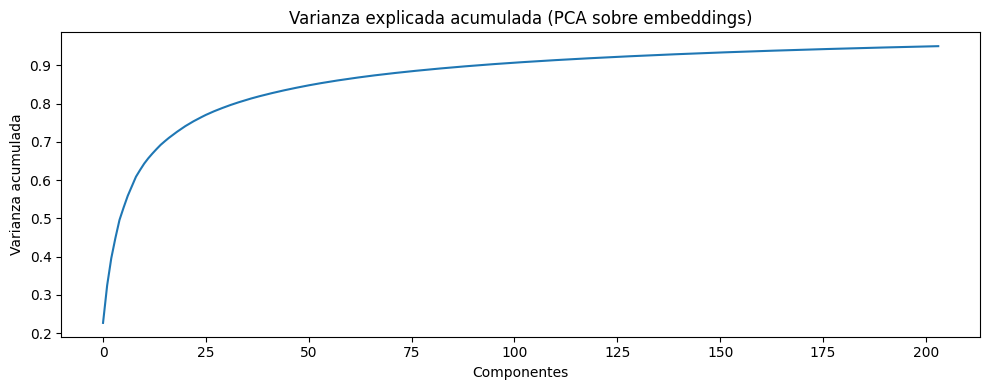

In [13]:
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_vt)
X_val_pca   = pca.transform(X_val_vt)
X_test_pca  = pca.transform(X_test_vt)

print("n_components:", pca.n_components_)
print("var acumulada:", pca.explained_variance_ratio_.sum())

cum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,4))
plt.plot(cum)
plt.title("Varianza explicada acumulada (PCA sobre embeddings)")
plt.xlabel("Componentes")
plt.ylabel("Varianza acumulada")
plt.tight_layout()
plt.show()

In [14]:
pipe_lr_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))
])

pipe_lr_pca.fit(X_train_pca, y_train)
pred_val_pca = pipe_lr_pca.predict(X_val_pca)
print(classification_report(y_val, pred_val_pca, target_names=classes))

              precision    recall  f1-score   support

    basophil       0.92      0.91      0.92       195
  eosinophil       0.90      0.95      0.93       320
erythroblast       0.93      0.94      0.93       249
          ig       0.85      0.86      0.86       320
  lymphocyte       0.93      0.93      0.93       194
    monocyte       0.90      0.83      0.86       227
  neutrophil       0.91      0.90      0.91       320
    platelet       0.98      0.98      0.98       320

    accuracy                           0.91      2145
   macro avg       0.92      0.91      0.91      2145
weighted avg       0.91      0.91      0.91      2145



### ANOVA SelectKBest

In [15]:
k = 128
skb = SelectKBest(score_func=f_classif, k=min(k, X_train.shape[1]))
X_train_k = skb.fit_transform(X_train, y_train)
X_val_k   = skb.transform(X_val)
X_test_k  = skb.transform(X_test)

print("Original:", X_train.shape, "Después ANOVA:", X_train_k.shape)

Original: (8577, 1286) Después ANOVA: (8577, 128)


### PCA sobre Kbest

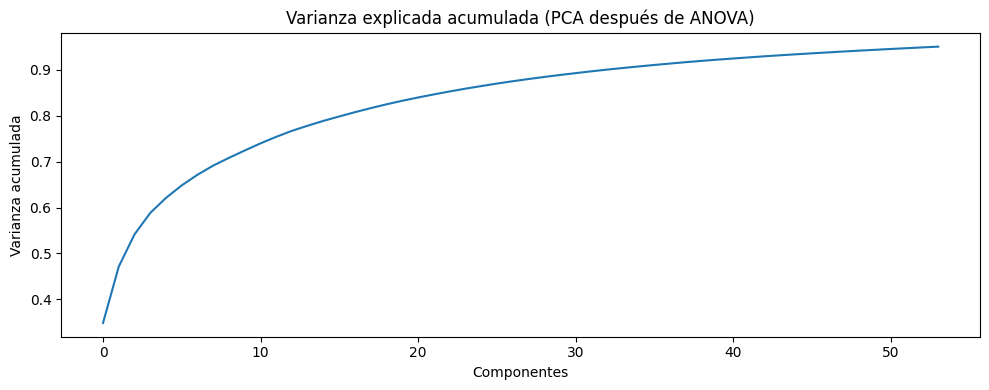

Componentes: 54 Var acumulada: 0.9507583


In [16]:
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_train_k_pca = pca.fit_transform(X_train_k)
X_val_k_pca   = pca.transform(X_val_k)

cum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,4))
plt.plot(cum)
plt.title("Varianza explicada acumulada (PCA después de ANOVA)")
plt.xlabel("Componentes")
plt.ylabel("Varianza acumulada")
plt.tight_layout()
plt.show()

print("Componentes:", pca.n_components_, "Var acumulada:", cum[-1])

#### Baseline vs selección vs selección + PCA


Impacto en la complejidad y el entrenamiento

La combinación de selección y extracción de características permite disminuir significativamente la dimensionalidad del espacio de entrada, lo que se traduce en:

- Menor complejidad computacional.
- Reducción del riesgo de sobreajuste.
- Aceleración del entrenamiento y la convergencia de los algoritmos.

Las comparaciones realizadas muestran que es posible mantener un desempeño competitivo utilizando subconjuntos de características o representaciones comprimidas mediante PCA, validando la efectividad de las decisiones tomadas durante la ingeniería de características.


In [17]:
pipe_base = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))])
pipe_base.fit(X_train, y_train)
pred_base = pipe_base.predict(X_val)

pipe_k = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))])
pipe_k.fit(X_train_k, y_train)
pred_k = pipe_k.predict(X_val_k)

pipe_k_pca = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))])
pipe_k_pca.fit(X_train_k_pca, y_train)
pred_k_pca = pipe_k_pca.predict(X_val_k_pca)

print("=== Baseline (all features) ===")
print(classification_report(y_val, pred_base, target_names=classes))
print("=== ANOVA SelectKBest ===")
print(classification_report(y_val, pred_k, target_names=classes))
print("=== ANOVA + PCA ===")
print(classification_report(y_val, pred_k_pca, target_names=classes))


=== Baseline (all features) ===
              precision    recall  f1-score   support

    basophil       0.93      0.92      0.93       195
  eosinophil       0.95      0.96      0.96       320
erythroblast       0.93      0.94      0.94       249
          ig       0.87      0.90      0.88       320
  lymphocyte       0.96      0.94      0.95       194
    monocyte       0.89      0.86      0.88       227
  neutrophil       0.93      0.93      0.93       320
    platelet       0.99      0.98      0.99       320

    accuracy                           0.93      2145
   macro avg       0.93      0.93      0.93      2145
weighted avg       0.93      0.93      0.93      2145

=== ANOVA SelectKBest ===
              precision    recall  f1-score   support

    basophil       0.92      0.93      0.92       195
  eosinophil       0.90      0.96      0.93       320
erythroblast       0.93      0.90      0.92       249
          ig       0.85      0.85      0.85       320
  lymphocyte       0

### PCA 2D por clase

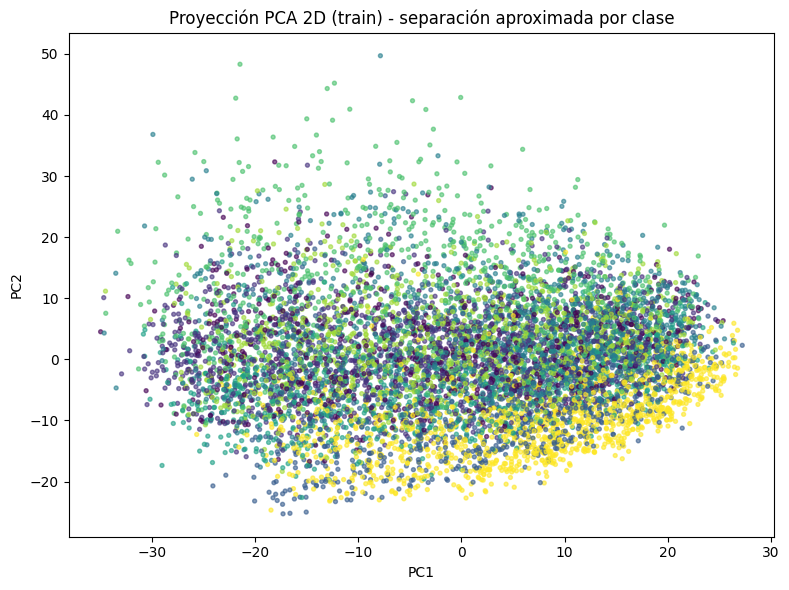

In [18]:
pca2 = PCA(n_components=2, random_state=RANDOM_SEED)
Z = pca2.fit_transform(StandardScaler().fit_transform(X_train))

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], s=8, alpha=0.6, c=y_train)
plt.title("Proyección PCA 2D (train) - separación aproximada por clase")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## Conclusiones de la fase de Preparación de los Datos

En el marco de CRISP-ML(Q), esta fase de **Preparación de los Datos** permitió transformar imágenes crudas en representaciones numéricas robustas y adecuadas para el aprendizaje automático. A través de la combinación de extracción de características profundas, construcción de variables adicionales, normalización, transformaciones y reducción de dimensionalidad, se logró mitigar sesgos por escala, mejorar la estabilidad del entrenamiento y reducir la complejidad del problema.

Estas decisiones sientan una base sólida para la fase de modelado, facilitando el desarrollo de modelos de clasificación multiclase más eficientes, interpretables y con mayor capacidad de generalización.


### Persistencia de artefactos para fases posteriores

Como parte de las buenas prácticas promovidas por CRISP-ML(Q), los datasets transformados, los
transformadores aprendidos y los extractores de características se almacenan como artefactos
reutilizables. Esta estrategia garantiza reproducibilidad, evita reprocesamiento innecesario y
facilita la transición hacia las fases de modelado, evaluación y despliegue.


In [20]:

os.makedirs("artifacts/data", exist_ok=True)

np.save("artifacts/data/X_train.npy", X_train)
np.save("artifacts/data/X_val.npy",   X_val)
np.save("artifacts/data/X_test.npy",  X_test)

np.save("artifacts/data/y_train.npy", y_train)
np.save("artifacts/data/y_val.npy",   y_val)
np.save("artifacts/data/y_test.npy",  y_test)

print("Datasets guardados")

Datasets guardados


In [21]:
np.save("artifacts/data/X_train_pca.npy", X_train_k_pca)
np.save("artifacts/data/X_val_pca.npy",   X_val_k_pca)

In [23]:
import joblib

os.makedirs("artifacts/transformers", exist_ok=True)

joblib.dump(pipe_lr_std, "artifacts/transformers/pipe_lr_std.joblib")
joblib.dump(pipe_lr_yj,  "artifacts/transformers/pipe_lr_yj.joblib")

joblib.dump(vt,  "artifacts/transformers/variance_threshold.joblib")
joblib.dump(skb, "artifacts/transformers/selectkbest.joblib")
joblib.dump(pca, "artifacts/transformers/pca.joblib")

print("✔ Pipelines y transformadores guardados")

✔ Pipelines y transformadores guardados


In [24]:
os.makedirs("artifacts/vision", exist_ok=True)

embed_model.save("artifacts/vision/embed_model.keras")
print("✔ Modelo de embeddings guardado")

✔ Modelo de embeddings guardado


In [25]:
import json

image_config = {
    "img_size": IMG_SIZE,
    "batch": BATCH,
    "preprocessing": "efficientnet_preprocess",
    "backbone": "EfficientNetB1"
}

with open("artifacts/vision/image_config.json", "w") as f:
    json.dump(image_config, f, indent=2)

print("✔ Configuración de imagen guardada")


✔ Configuración de imagen guardada


In [26]:
os.makedirs("artifacts/metadata", exist_ok=True)

# Clases
with open("artifacts/metadata/classes.json", "w") as f:
    json.dump(classes, f, indent=2)

# Decisiones de FE
fe_config = {
    "feature_engineering": [
        "deep_embeddings_efficientnet",
        "brightness",
        "contrast",
        "colorfulness",
        "rgb_ratios"
    ],
    "scaling": "StandardScaler",
    "power_transform": "Yeo-Johnson",
    "selection": ["VarianceThreshold", "ANOVA SelectKBest"],
    "extraction": "PCA (95% variance)"
}

with open("artifacts/metadata/fe_config.json", "w") as f:
    json.dump(fe_config, f, indent=2)

print("✔ Metadata guardada")


✔ Metadata guardada


## Referencias

Galli, S. (2022). *Python Feature Engineering Cookbook*. Packt Publishing.

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*, 770–778.

Howard, A. G., Sandler, M., Chu, G., Chen, L. C., Chen, B., Tan, M., … Adam, H. (2019). Searching for MobileNetV3. *Proceedings of the IEEE/CVF International Conference on Computer Vision*, 1314–1324.

Kumar Mukhiya, S., & Ahmed, U. (2020). *Hands-On Exploratory Data Analysis with Python*. Packt Publishing.

Tan, M., & Le, Q. (2019). EfficientNet: Rethinking model scaling for convolutional neural networks. *Proceedings of the 36th International Conference on Machine Learning*, 6105–6114.

Visengeriyeva, L., Kammer, A., Bär, I., Kniesz, A., & Plöd, M. (2023). *CRISP-ML(Q): The ML Lifecycle Process*. INNOQ.
